In [1]:
%pwd

'/srv/cui-bee/agheinze/DATA/externalSetups/FLIM_HHU/tttrlib/Colab'

In [2]:
import tttrlib
import pathlib
import numpy as np
import pandas as pd
import pylab as plt

In [16]:
burst_file = './SingleMolecule/int_tau.csv' # CSV file containing the burst selection

data_path = './SingleMolecule/LP-344-525+7.5uM-UP-344-525_2' # Folder containing the measurement data
channels = [0, 8] # Replace with the specific channel you want to analyze

# Define binning (e.g., set 64 bins) and specify the target channel
binning = 4  # Adjust as needed
file_type = 'SPC-130'

output_fn = './SingleMolecule/decay_lf.txt'

In [17]:
df = pd.read_csv(burst_file, sep='\t')
list(df.columns.values)

['Unnamed: 0',
 'First Photon',
 'Last Photon',
 'Duration (ms)',
 'Mean Macro Time (ms)',
 'Number of Photons',
 'Count Rate (KHz)',
 'First File',
 'Last File',
 'First Photon (green)',
 'Last Photon (green)',
 'Duration (green) (ms)',
 'Mean Macrotime (green) (ms)',
 'Number of Photons (green)',
 'Green Count Rate (KHz)',
 'S prompt green (kHz) | 0-4095',
 'First Photon (red)',
 'Last Photon (red)',
 'Duration (red) (ms)',
 'Mean Macrotime (red) (ms)',
 'Number of Photons (red)',
 'Red Count Rate (KHz)',
 'S prompt red (kHz) | 0-4095',
 'First Photon (yellow)',
 'Last Photon (yellow)',
 'Duration (yellow) (ms)',
 'Mean Macrotime (yellow) (ms)',
 'Number of Photons (yellow)',
 'Yellow Count Rate (KHz)',
 'S prompt yellow (kHz) | 0-4095',
 'S delayed green (kHz) | 2048-4095',
 'S delayed red (kHz) | 2048-4095',
 'S delayed yellow (kHz) | 2048-4095',
 'Ng-p-all',
 'Ng-s-all',
 'Number of Photons (fit window) (green)',
 '2I*  (green)',
 'Tau (green)',
 'gamma (green)',
 'r0 (green)',
 '

In [18]:
# Define the proximity ratio computation based on columns in your data
# For example, here I assume the proximity ratio is calculated as:
# proximity_ratio = Number of Photons (green) / (Number of Photons (green) + Number of Photons (red))

df['proximity_ratio'] = df['Number of Photons (green)'] / (
    df['Number of Photons (green)'] + df['Number of Photons (red)']
)

# Select rows where proximity ratio is between 0.3 and 0.55 for low FRET population
subset_df = df[(df['proximity_ratio'] >= 0.30) & (df['proximity_ratio'] <= 0.55)]

# Select rows where proximity ratio is between 0.75 and 1.0 for high FRET population
#subset_df = df[(df['proximity_ratio'] >= 0.75) & (df['proximity_ratio'] <= 1.0)]

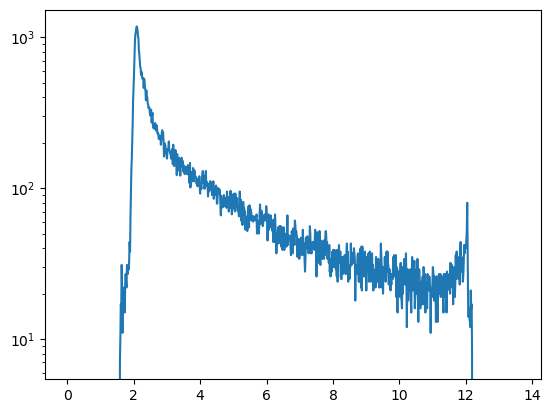

In [19]:
tttrs = dict()
# Iterate over each row in the filtered subset
hists = list()
for _, row in subset_df.iterrows():
    file_name = row['First File']  # Assuming 'First File' has the file paths
    first_photon = row['First Photon']
    last_photon = row['Last Photon']
    filename = pathlib.Path(file_name).name
    fn = pathlib.Path(data_path) / filename
    try:
        tttr_data = tttrs[filename]
    except KeyError:
        d = tttrlib.TTTR(fn.as_posix(), file_type)
        rout = d.routing_channels
        idx = np.where(np.isin(rout, channels))[0]
        tttr_data = d[idx]
        tttrs[filename] = tttr_data
        
    # Generate a microtime histogram for the selected channel photons
    microtime_hist, bin_edges = tttr_data[first_photon:last_photon].get_microtime_histogram(binning)
    hists.append(microtime_hist)

hist = np.sum(hists, axis=0)
bin_edges *= 1e9  # To convert time axis into nanoseconds

plt.semilogy(bin_edges, hist)

np.savetxt(output_fn,  np.vstack([bin_edges, hist]).T)